In [54]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [36]:
# Load the data
df = pd.read_csv('/home/tom/Python/Machine learning/pytorch/rnn/XAU_USD Historical Data2.csv' , thousands=',')

In [37]:
# Extract 'Date' and 'Close' columns
df = df[['Date', 'Open']]

# Convert 'Date' to datetime and sort by date
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df

,Date,Open
6220,2000-02-02,282.88
6219,2000-02-03,285.00
6218,2000-02-04,287.75
6217,2000-02-07,310.00
6216,2000-02-08,302.25
...,...,...
4,2023-12-18,2020.09
3,2023-12-19,2027.30
2,2023-12-20,2040.34
1,2023-12-21,2029.44


In [38]:
# Normalize the 'Close' values
scaler = MinMaxScaler()

# The column 'Open' is changed to range between -1 and +1
df['Open'] = scaler.fit_transform(df['Open'].values.reshape(-1, 1))

# Convert the DataFrame to a PyTorch tensor and add one additional dimension
open_values = torch.tensor(df['Open'].values.astype(np.float32)).view(-1, 1)
open_values.shape

torch.Size([6221, 1])

In [39]:
# Define a function to create input sequences and corresponding targets
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length:i+seq_length+1]
        sequences.append(seq)
        targets.append(target)
    return torch.stack(sequences), torch.stack(targets)

In [40]:
# Define hyperparameters
sequence_length = 10
batch_size = 64
epochs = 100
learning_rate = 0.001

In [41]:
# Create sequences and targets
sequences, targets = create_sequences(open_values, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))

train_sequences, test_sequences = sequences[:split_index], sequences[split_index:]
train_targets, test_targets = targets[:split_index], targets[split_index:]

In [42]:
print('final X shape ', sequences.shape)
print('final Y shape ', targets.shape)

final X shape  torch.Size([6211, 10, 1])
final Y shape  torch.Size([6211, 1, 1])


In [43]:
# Create DataLoader for training
train_dataset = TensorDataset(train_sequences, train_targets)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [48]:
# Test the model on the testing set
test_dataset = TensorDataset(test_sequences, test_targets)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [44]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=1, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [56]:
# Instantiate the model
model = LSTMModel()

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(epochs):
    for batch_seq, batch_target in train_dataloader:
        optimizer.zero_grad()
        output = model(batch_seq)
        loss = criterion(output.squeeze(), batch_target.squeeze())
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')



Epoch 1/100, Loss: 0.003045229706913233
Epoch 2/100, Loss: 0.000155938440002501
Epoch 3/100, Loss: 8.870785677572712e-05
Epoch 4/100, Loss: 9.279412915930152e-05
Epoch 5/100, Loss: 0.00015336324577219784
Epoch 6/100, Loss: 7.09403830114752e-05
Epoch 7/100, Loss: 7.554450712632388e-05
Epoch 8/100, Loss: 6.902757741045207e-05
Epoch 9/100, Loss: 0.00010562239913269877
Epoch 10/100, Loss: 0.00011488484597066417
Epoch 11/100, Loss: 0.0001650781778153032
Epoch 12/100, Loss: 0.00014882601681165397
Epoch 13/100, Loss: 0.00019997367053292692
Epoch 14/100, Loss: 9.744695853441954e-05
Epoch 15/100, Loss: 0.00016208275337703526
Epoch 16/100, Loss: 0.00018278186325915158
Epoch 17/100, Loss: 7.186962466221303e-05
Epoch 18/100, Loss: 7.24128694855608e-05
Epoch 19/100, Loss: 7.616573566338047e-05
Epoch 20/100, Loss: 0.00029237946728244424
Epoch 21/100, Loss: 0.00010459635814186186
Epoch 22/100, Loss: 9.019287244882435e-05
Epoch 23/100, Loss: 9.028146450873464e-05
Epoch 24/100, Loss: 0.0001014585723169

In [57]:
# Make predictions for the next 10 days
with torch.no_grad():
    future_dates = pd.date_range(df['Date'].iloc[-1], periods=10, freq='B')[1:]
    future_values = open_values[-sequence_length:].clone()

    for i in range(10):
        input_sequence = future_values[-sequence_length:].view(1, -1, 1)
        prediction = model(input_sequence)
        future_values = torch.cat([future_values, prediction.view(-1, 1)])

# Inverse transform the predicted values
predicted_values = scaler.inverse_transform(future_values.numpy())

# Check and adjust lengths
min_length = min(len(future_dates), len(predicted_values.flatten()))
future_dates = future_dates[:min_length]
predicted_values = predicted_values.flatten()[:min_length]

# Create a DataFrame for the predicted values
predicted_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': predicted_values
})

# Print the predicted DataFrame
print(predicted_df)


        Date  Predicted_Close
0 2023-12-25      2003.599976
1 2023-12-26      1981.590088
2 2023-12-27      1979.739990
3 2023-12-28      2026.589966
4 2023-12-29      2035.800049
5 2024-01-01      2020.090088
6 2024-01-02      2027.299927
7 2024-01-03      2040.340088
8 2024-01-04      2029.440063


/home/tom/apps/cache/python-envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/tom/apps/cache/python-envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([27, 1, 1])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Test Loss: 0.0015998776056221687


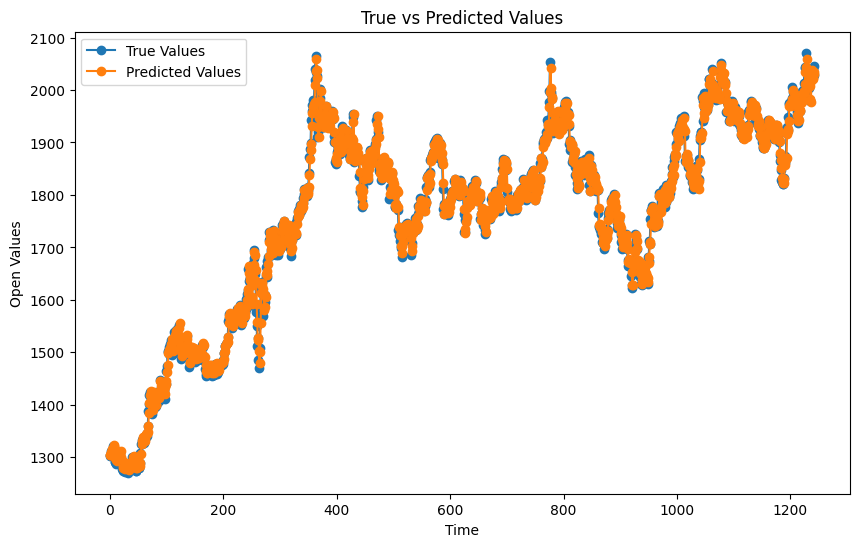

In [55]:
with torch.no_grad():
    test_loss = 0.0
    all_predictions = []

    for batch_seq, batch_target in test_dataloader:
        output = model(batch_seq)
        test_loss += criterion(output, batch_target).item()
        all_predictions.append(output.numpy())

    average_test_loss = test_loss / len(test_dataloader)
    print(f'Average Test Loss: {average_test_loss}')

# Concatenate all predictions and targets for plotting
all_predictions = np.concatenate(all_predictions, axis=0)

# Inverse transform the predicted and target values
predicted_values = scaler.inverse_transform(all_predictions)

# Reshape test_targets to remove the additional dimension
test_targets = test_targets.reshape(-1, 1)
true_values = scaler.inverse_transform(test_targets)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(true_values, label='True Values', marker='o')
plt.plot(predicted_values, label='Predicted Values', marker='o')
plt.title('True vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Open Values')
plt.legend()
plt.show()